# Decision Tree & Random Forest for BOM Data

## Import Packages

In [58]:
import numpy as np
import pandas as pd
import datetime
import random
import sklearn

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# Ignore useless warnings 
import warnings
warnings.filterwarnings(action="ignore")                 

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sm
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from prettytable import PrettyTable
import shap

In [60]:
import os
os.getcwd()

'/Users/danny/Desktop/MDS/master 4/CITS 5553 Data Science Capstone Project/Group/Energy-Usage-Prediction-Project/Zheyu/Used Data'

## Read Data

In [61]:
os.chdir('/Users/danny/Desktop/MDS/master 4/CITS 5553 Data Science Capstone Project/Group/Energy-Usage-Prediction-Project/Zheyu/Used Data')

In [62]:
df = pd.read_csv('processedData_final_final.csv', index_col = 0)
df.head(100)

Operational Demand (MW)  Transpiration  Rain  Evaporation  \
Date                                                                    
2009-01-01                95141.184           11.2   0.0         11.6   
2009-01-02               108058.504           10.2   0.0         12.8   
2009-01-03                95788.860            9.4   0.0         11.8   
2009-01-04                93777.404           10.5   0.0         11.2   
2009-01-05               112678.424           11.9   0.0         11.4   
...                             ...            ...   ...          ...   
2009-04-06                91199.480            7.6   0.0          8.4   
2009-04-07                94116.376            7.1   0.0          7.4   
2009-04-08                96776.066            7.3   0.0          7.4   
2009-04-09                97174.566            6.8   0.0          7.2   
2009-04-10                83279.322            9.1   0.0          7.8   

            Max Temp  Min Temp  Max Hum  Min Hum  Av Wind  Solar Rad  ...  \
Date                                                                  ...   
2009-01-01      37.2      18.8     65.0     20.0     6.10      34.01  ...   
2009-01-02      36.1      21.9     70.0     25.0     5.31      34.25  ...   
2009-01-03      34.4      20.3     79.0     29.0     5.45      34.11  ...   
2009-01-04      36.5      18.5     62.0     20.0     5.25      34.05  ...   
2009-01-05      37.2      21.8     63.0     17.0     6.77      34.18  ...   
...              ...       ...      ...      ...      ...        ...  ...   
2009-04-06      29.2      14.7     64.0     17.0     6.36      22.32  ...   
2009-04-07      31.6      17.2     52.0     16.0     4.54      22.04  ...   
2009-04-08      33.6      17.4     55.0     11.0     4.44      20.64  ...   
2009-04-09      34.0      14.6     51.0     11.0     3.71      20.96  ...   
2009-04-10      35.5      17.2     65.0      9.0     6.15      20.87  ...   

            sin_month  cos_month  sin_Day_of_week  cos_Day_of_week  \
Date                                                                 
2009-01-01   0.500000   0.866025         0.433884        -0.900969   
2009-01-02   0.500000   0.866025        -0.433884        -0.900969   
2009-01-03   0.500000   0.866025        -0.974928        -0.222521   
2009-01-04   0.500000   0.866025        -0.781831         0.623490   
2009-01-05   0.500000   0.866025         0.000000         1.000000   
...               ...        ...              ...              ...   
2009-04-06   0.866025  -0.500000         0.000000         1.000000   
2009-04-07   0.866025  -0.500000         0.781831         0.623490   
2009-04-08   0.866025  -0.500000         0.974928        -0.222521   
2009-04-09   0.866025  -0.500000         0.433884        -0.900969   
2009-04-10   0.866025  -0.500000        -0.433884        -0.900969   

            sin_Day_of_month  cos_Day_of_month  sin_Day_of_year  \
Date                                                              
2009-01-01          0.207912          0.978148         0.017213   
2009-01-02          0.406737          0.913545         0.034422   
2009-01-03          0.587785          0.809017         0.051620   
2009-01-04          0.743145          0.669131         0.068802   
2009-01-05          0.866025          0.500000         0.085965   
...                      ...               ...              ...   
2009-04-06          0.951057          0.309017         0.996659   
2009-04-07          0.994522          0.104528         0.995105   
2009-04-08          0.994522         -0.104528         0.993257   
2009-04-09          0.951057         -0.309017         0.991114   
2009-04-10          0.866025         -0.500000         0.988678   

            cos_Day_of_year  sin_week_of_year  cos_week_of_year  
Date                                                             
2009-01-01         0.999852          0.120537          0.992709  
2009-01-02         0.999407          0.120537          0.992709  
2009-01-03   

## Data Cleaning

In [63]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in df.columns:
    if df[i].dtype not in numeric_dtypes:
        df[i]=df[i].str.replace(" ",'') # Replace all ' ' into none
        df[i]=pd.to_numeric(df[i])

In [64]:
df.index = pd.to_datetime(df.index,format= '%Y-%m-%d')
# df.index = pd.to_datetime(df.index,format= '%d/%m/%Y')
select_col=['Operational Demand (MW)', 'Transpiration', 'Rain', 'Evaporation',
       'Max Temp', 'Min Temp', 'Max Hum', 'Min Hum', 'Av Wind', 'Solar Rad',
       'state_holiday', 'sin_month', 'cos_month', 'sin_Day_of_week',
       'cos_Day_of_week', 'sin_Day_of_month', 'cos_Day_of_month',
       'sin_Day_of_year', 'cos_Day_of_year', 'sin_week_of_year',
       'cos_week_of_year']
y_col=['Operational Demand (MW)']
x_col=list(set(select_col)-set(y_col))

model_df=df[select_col].fillna(method='ffill',axis=0)
test_dat = model_df[(model_df.index >= '2021-12-01') & ('2022-03-01' > model_df.index)]
training_dat = model_df[model_df.index < '2021-12-01']

# training_dat = model_df[(model_df.index < '2021-12-01') | ('2022-03-01' <= model_df.index)]

In [65]:
X_train = training_dat.drop('Operational Demand (MW)',axis=1)
y_train = training_dat['Operational Demand (MW)']

X_test = test_dat.drop('Operational Demand (MW)', axis = 1) 
y_test = test_dat['Operational Demand (MW)']

## Features used

In [66]:
training_dat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4712 entries, 2009-01-01 to 2021-11-30
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Operational Demand (MW)  4712 non-null   float64
 1   Transpiration            4712 non-null   float64
 2   Rain                     4712 non-null   float64
 3   Evaporation              4712 non-null   float64
 4   Max Temp                 4712 non-null   float64
 5   Min Temp                 4712 non-null   float64
 6   Max Hum                  4712 non-null   float64
 7   Min Hum                  4712 non-null   float64
 8   Av Wind                  4712 non-null   float64
 9   Solar Rad                4712 non-null   float64
 10  state_holiday            4712 non-null   int64  
 11  sin_month                4712 non-null   float64
 12  cos_month                4712 non-null   float64
 13  sin_Day_of_week          4712 non-null   float64
 14  cos_Da

In [67]:
training_dat.head(1)

Operational Demand (MW)  Transpiration  Rain  Evaporation  \
Date                                                                    
2009-01-01                95141.184           11.2   0.0         11.6   

            Max Temp  Min Temp  Max Hum  Min Hum  Av Wind  Solar Rad  ...  \
Date                                                                  ...   
2009-01-01      37.2      18.8     65.0     20.0      6.1      34.01  ...   

            sin_month  cos_month  sin_Day_of_week  cos_Day_of_week  \
Date                                                                 
2009-01-01        0.5   0.866025         0.433884        -0.900969   

            sin_Day_of_month  cos_Day_of_month  sin_Day_of_year  \
Date                                                              
2009-01-01          0.207912          0.978148         0.017213   

            cos_Day_of_year  sin_week_of_year  cos_week_of_year  
Date                                                             
2009-01-01         0.999852          0.120537          0.992709  

[1 rows x 21 columns]

## Function Create

In [68]:
def ImportanceDisplay(model):
    if 'grid' in model:
        impo_lst=[model,'.best_estimator_.feature_importances_']
    else:
        impo_lst=[model,'.feature_importances_']
    impo_str=''
    importance = eval(impo_str.join(impo_lst))
    #importance = rf_reg.feature_importances_
    table = PrettyTable(['Factors','Score'])
    for i,v in enumerate(importance):
	    table.add_row([x_col[i],round(v,4)])
    print(table)
def ModelScore(true,predict):
    print("Mean absolute error = ",round(sm.mean_absolute_error(true,predict),4))
    print("Mean squared error = ",round(sm.mean_squared_error(true,predict),4))
    print("Median absolute error = ",round(sm.median_absolute_error(true,predict),4))
    print("explained variance error = ",round(sm.explained_variance_score(true,predict),4))
    print("R2 error = ",round(sm.r2_score(true,predict),4))

## Threshold Determine

125524.3907

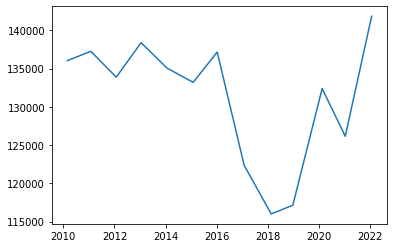

In [69]:
new_df_summer = pd.DataFrame()
for i in range(2009,2022):
    s0 = str(i) + '-12-01'
    s1 = str(i+1) + '-03-01'
    df_summer = model_df[(model_df.index >= s0) & (s1 > model_df.index)]
    order_table = df_summer.sort_values('Operational Demand (MW)',ascending=False)
    nr = order_table[3:4]
    new_df_summer = pd.concat((new_df_summer,nr))
od = new_df_summer['Operational Demand (MW)']
plt.plot(od.index,od)
# year_choose = 3 # number of year we choose to get the average threshold
# ave_threshold = sum(od[-4:-1])/year_choose
# ave_threshold= sum(od[:-1])/len(od[:-1]) # average of lowest of peak4 of all previous summers
df_summer = model_df[(model_df.index >= '2020-12-01') & ('2021-03-01' > model_df.index)] # 95% of last summer as threshold
ave_threshold = np.percentile(df_summer['Operational Demand (MW)'],95)
ave_threshold


In [70]:
od

Date
2010-02-26    136032.698
2011-01-28    137258.610
2012-01-26    133880.634
2013-01-15    138378.508
2014-01-20    135063.762
2015-01-29    133198.826
2016-01-07    137159.804
2017-01-26    122359.630
2018-02-16    116001.592
2018-12-22    117137.326
2020-02-14    132391.970
2021-01-09    126148.326
2022-01-21    141839.600
Name: Operational Demand (MW), dtype: float64

## Decision Tree

In [71]:
tree_reg = DecisionTreeRegressor(random_state=42)

param_grid_dtree = dict(
    max_depth =[None,15,20,25],
    min_samples_leaf=[5,50,100])

grid_dtree=GridSearchCV(tree_reg, param_grid_dtree, cv=3, scoring='neg_root_mean_squared_error',verbose=2,return_train_score=True)

grid_dtree.fit(X_train,y_train)
y_pred_tree_test = grid_dtree.predict(X_test)
print(grid_dtree.best_estimator_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.0s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.0s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.0s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.0s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.0s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.0s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.0s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.0s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   0.0s
[CV] END ...................max_depth=15, min_sa

In [72]:
tree_model = DecisionTreeRegressor(min_samples_leaf=50, random_state=42)
tree_model.fit(X_train,y_train)
y_pred_tree = tree_model.predict(X_test)

In [73]:
dtscore=ModelScore(y_test,y_pred_tree)
dtscore
ny_test=len(y_test)
mape = (sum(np.abs((y_test - y_pred_tree)/y_test))/ny_test)*100
print('Mape', mape)
ImportanceDisplay('tree_model')

Mean absolute error =  7075.2295
Mean squared error =  77468890.4124
Median absolute error =  5981.712
explained variance error =  0.7825
R2 error =  0.7807
Mape 6.6391658391784905
+------------------+--------+
|     Factors      | Score  |
+------------------+--------+
|     Min Hum      |  0.0   |
| cos_Day_of_year  | 0.0024 |
|     Max Temp     | 0.0027 |
|    Solar Rad     | 0.4811 |
|     Min Temp     | 0.1955 |
| cos_week_of_year | 0.0022 |
|    sin_month     | 0.0053 |
|  state_holiday   | 0.0024 |
|     Max Hum      | 0.0385 |
| sin_Day_of_month |  0.0   |
|    cos_month     |  0.0   |
|       Rain       |  0.0   |
| sin_Day_of_week  | 0.1786 |
|     Av Wind      |  0.0   |
| sin_Day_of_year  | 0.0004 |
| cos_Day_of_month | 0.0008 |
|  Transpiration   | 0.009  |
|   Evaporation    | 0.0806 |
| sin_week_of_year |  0.0   |
| cos_Day_of_week  | 0.0007 |
+------------------+--------+


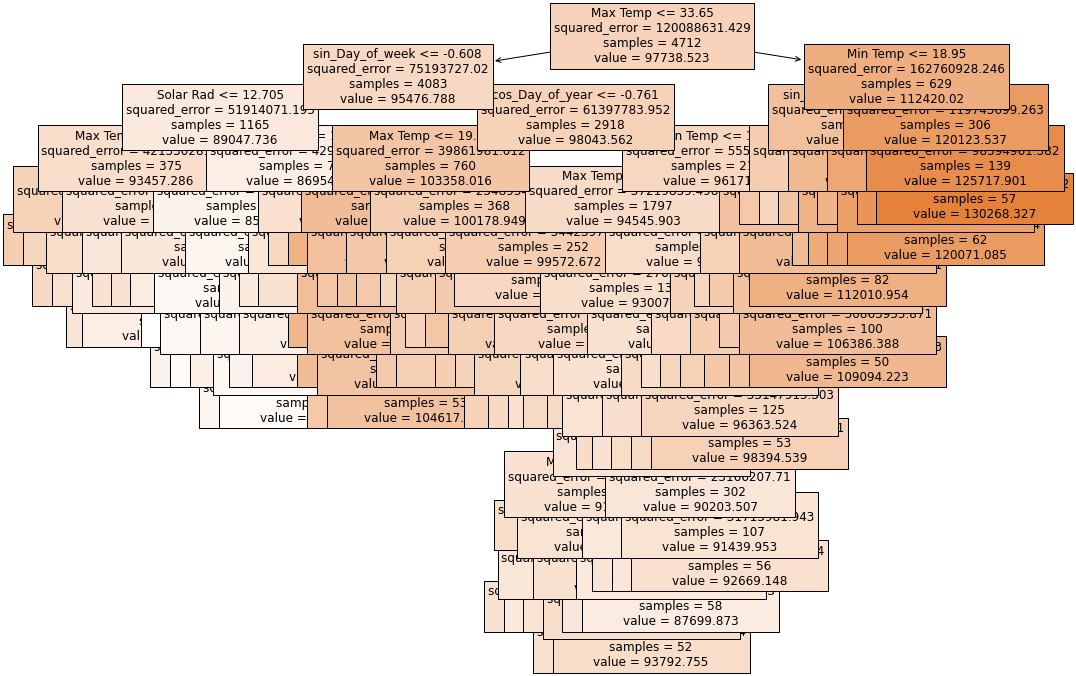

In [74]:
fig = plt.figure(figsize=(16,12))
a_rf_smote = plot_tree(tree_model, feature_names=X_train.columns, fontsize=12, filled=True, class_names=['0', '1'])

In [75]:
y_pred_tree = pd.DataFrame(y_pred_tree)
predict_table_dt = pd.DataFrame(y_test)
predict_table_dt.insert(1,'predict',y_pred_tree)
predict_table_dt

Operational Demand (MW)        predict
Date                                              
2021-12-01                81389.002   90090.248157
2021-12-02                83692.208   92669.147571
2021-12-03                87674.768   97058.771170
2021-12-04                86230.014   92306.394576
2021-12-05                83724.146   96667.727529
...                             ...            ...
2022-02-24               115161.260  113749.944468
2022-02-25               116923.464  102349.005647
2022-02-26               106125.340  109832.620509
2022-02-27               105071.118   96209.420955
2022-02-28               115652.308  115956.254080

[90 rows x 2 columns]

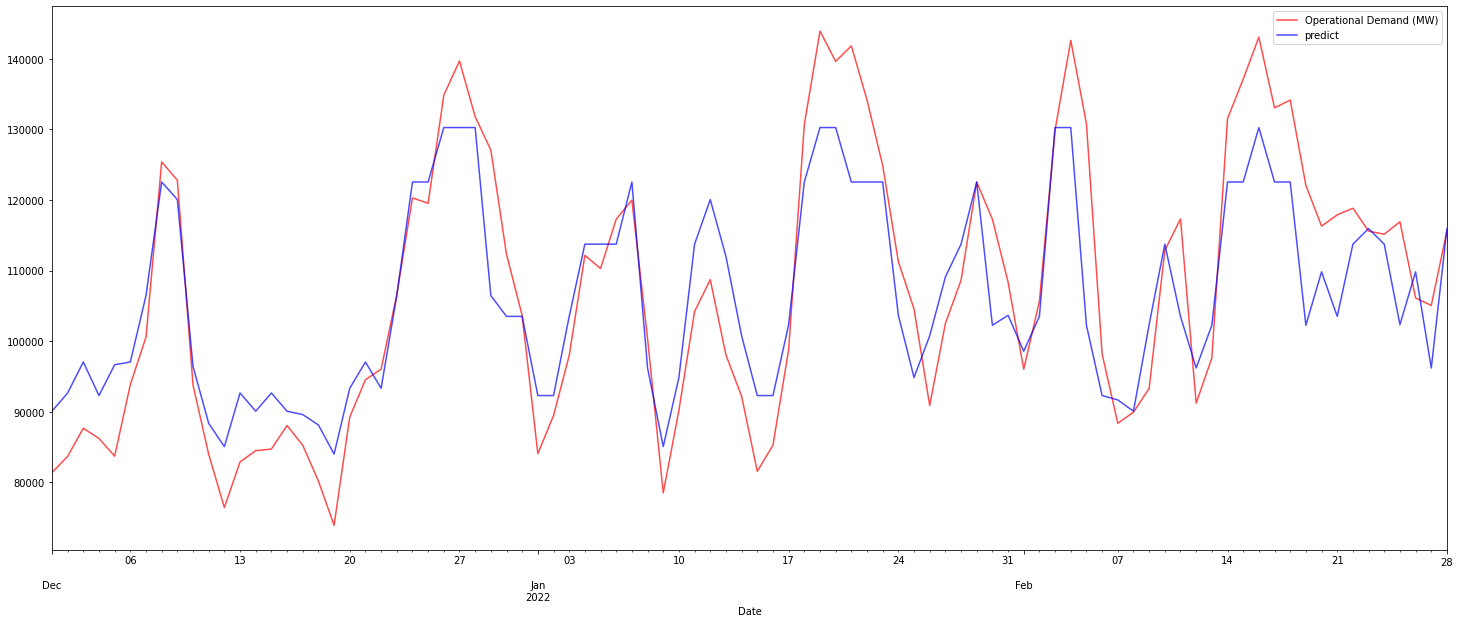

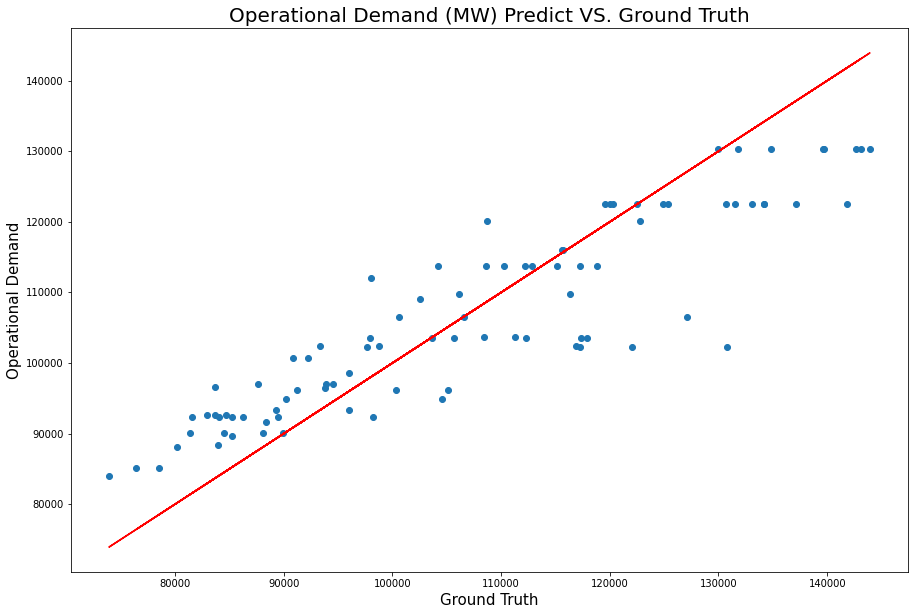

In [76]:
predict_table_dt.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table_dt['Operational Demand (MW)'], predict_table_dt['predict'])
plt.plot(predict_table_dt['Operational Demand (MW)'],predict_table_dt['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [77]:
peak_day = 5 # number of top peak day we choose
peak_true_tree = predict_table_dt.sort_values('Operational Demand (MW)',ascending=False)[:peak_day]
truelst = peak_true_tree.index.tolist()
# peak_predict = predict_table_dt.sort_values('predict',ascending=False)[:peak_day]
peak_predict_tree = predict_table_dt[predict_table_dt['predict'] > ave_threshold]
predictlst=peak_predict_tree.index.tolist()
acc = len([x for x in truelst if x in predictlst])/peak_day
print('Accuracy for predicting peak 5 day:',acc)

Accuracy for predicting peak 5 day: 0.8


In [78]:
peak_true_tree

Operational Demand (MW)        predict
Date                                              
2022-01-19               143929.714  130268.326807
2022-02-16               143068.538  130268.326807
2022-02-04               142620.646  130268.326807
2022-01-21               141839.600  122554.800927
2021-12-27               139702.954  130268.326807

In [79]:
peak_predict_tree

Operational Demand (MW)        predict
Date                                              
2021-12-26               134848.128  130268.326807
2021-12-27               139702.954  130268.326807
2021-12-28               131818.396  130268.326807
2022-01-19               143929.714  130268.326807
2022-01-20               139644.016  130268.326807
2022-02-03               129938.672  130268.326807
2022-02-04               142620.646  130268.326807
2022-02-16               143068.538  130268.326807

## Random Forest

In [80]:
forest = RandomForestRegressor(random_state=42)

param_grid_forest = dict(
    max_depth =[None,15,20,25],
    min_samples_leaf=[5,50,100])

grid_forest=GridSearchCV(forest, param_grid_forest, cv=3, scoring='neg_root_mean_squared_error',verbose=2,return_train_score=True)

grid_forest.fit(X_train, y_train)
y_predict_forest_test = grid_forest.predict(X_test)
print(grid_forest.best_estimator_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   1.9s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   1.7s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   1.7s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   1.0s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   1.0s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   1.0s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.9s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.8s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.8s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   1.7s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   1.6s
[CV] END ...................max_depth=15, min_sa

In [81]:
forest_model = RandomForestRegressor(max_depth=15, min_samples_leaf=5, random_state=42)
forest_model.fit(X_train,y_train)
y_predict_forest = forest_model.predict(X_test)

In [82]:
rfscore=ModelScore(y_test,y_predict_forest)
rfscore
mape = (sum(np.abs((y_test - y_predict_forest)/y_test))/ny_test)*100
print('Mape', mape)
ImportanceDisplay('forest_model')

Mean absolute error =  6438.3182
Mean squared error =  54629688.7791
Median absolute error =  6305.5649
explained variance error =  0.8455
R2 error =  0.8454
Mape 6.158896462052826
+------------------+--------+
|     Factors      | Score  |
+------------------+--------+
|     Min Hum      | 0.0069 |
| cos_Day_of_year  | 0.0036 |
|     Max Temp     | 0.0118 |
|    Solar Rad     | 0.3788 |
|     Min Temp     | 0.235  |
| cos_week_of_year | 0.0087 |
|    sin_month     | 0.011  |
|  state_holiday   | 0.0146 |
|     Max Hum      | 0.037  |
| sin_Day_of_month | 0.0139 |
|    cos_month     | 0.0011 |
|       Rain       | 0.0017 |
| sin_Day_of_week  | 0.1557 |
|     Av Wind      | 0.0031 |
| sin_Day_of_year  | 0.0077 |
| cos_Day_of_month | 0.0062 |
|  Transpiration   | 0.0168 |
|   Evaporation    | 0.0745 |
| sin_week_of_year | 0.0051 |
| cos_Day_of_week  | 0.0065 |
+------------------+--------+


In [83]:
y_predict_forest = pd.DataFrame(y_predict_forest)
predict_table_rf = pd.DataFrame(y_test)
predict_table_rf.insert(1,'predict',y_predict_forest)
predict_table_rf

Operational Demand (MW)        predict
Date                                              
2021-12-01                81389.002   89537.651881
2021-12-02                83692.208   93783.573446
2021-12-03                87674.768   97402.457677
2021-12-04                86230.014   91980.477296
2021-12-05                83724.146   96833.780176
...                             ...            ...
2022-02-24               115161.260  115979.387154
2022-02-25               116923.464  107264.546732
2022-02-26               106125.340  103882.975007
2022-02-27               105071.118  100081.579094
2022-02-28               115652.308  120214.459965

[90 rows x 2 columns]

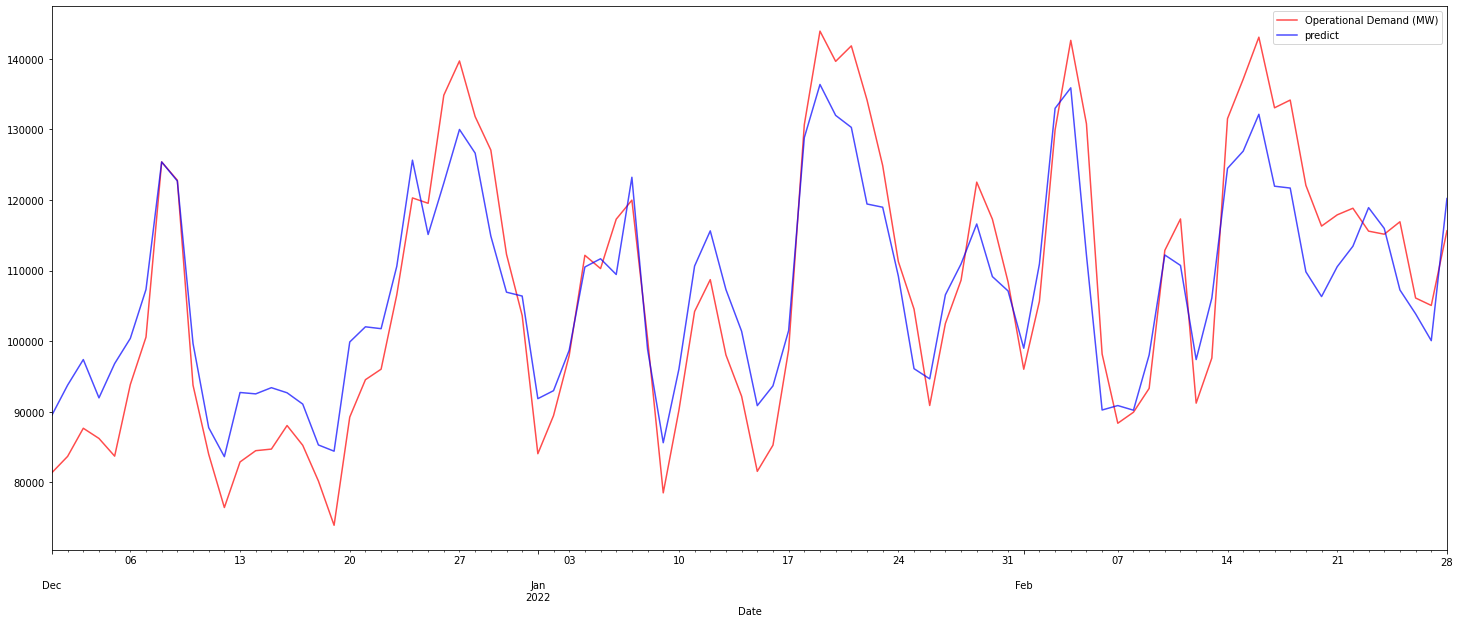

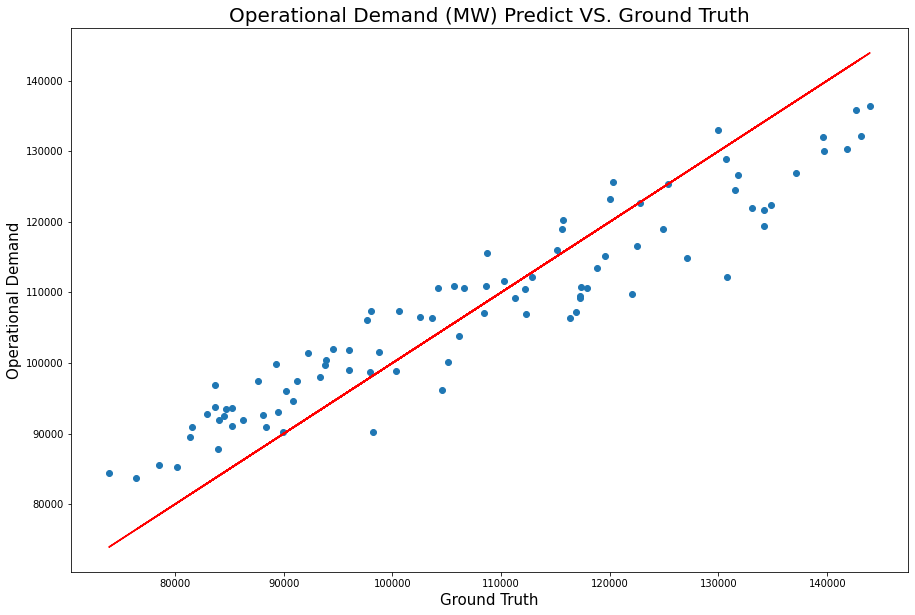

In [84]:
predict_table_rf.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table_rf['Operational Demand (MW)'], predict_table_rf['predict'])
plt.plot(predict_table_rf['Operational Demand (MW)'],predict_table_rf['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [85]:
# peak_day = predict_table[predict_table['predict'] >= ave_threshold]
# peak_day

In [86]:
peak_day = 5 # number of top peak day we choose
peak_true = predict_table_rf.sort_values('Operational Demand (MW)',ascending=False)[:peak_day]
truelst = peak_true.index.tolist()
# peak_predict = predict_table_rf.sort_values('predict',ascending=False)[:peak_day]
peak_predict = predict_table_rf[predict_table_rf['predict'] > ave_threshold]
predictlst=peak_predict.index.tolist()
acc = len([x for x in truelst if x in predictlst])/peak_day
print('Accuracy for predicting peak 5 day:',acc)

Accuracy for predicting peak 5 day: 1.0


In [87]:
peak_true

Operational Demand (MW)        predict
Date                                              
2022-01-19               143929.714  136371.617018
2022-02-16               143068.538  132147.260637
2022-02-04               142620.646  135896.589561
2022-01-21               141839.600  130292.162753
2021-12-27               139702.954  129996.257821

In [88]:
peak_predict

Operational Demand (MW)        predict
Date                                              
2021-12-24               120300.800  125646.807112
2021-12-27               139702.954  129996.257821
2021-12-28               131818.396  126644.412299
2022-01-18               130673.158  128837.656229
2022-01-19               143929.714  136371.617018
2022-01-20               139644.016  131990.507902
2022-01-21               141839.600  130292.162753
2022-02-03               129938.672  132994.612224
2022-02-04               142620.646  135896.589561
2022-02-15               137116.820  126923.453758
2022-02-16               143068.538  132147.260637

## Plot of DT & RF

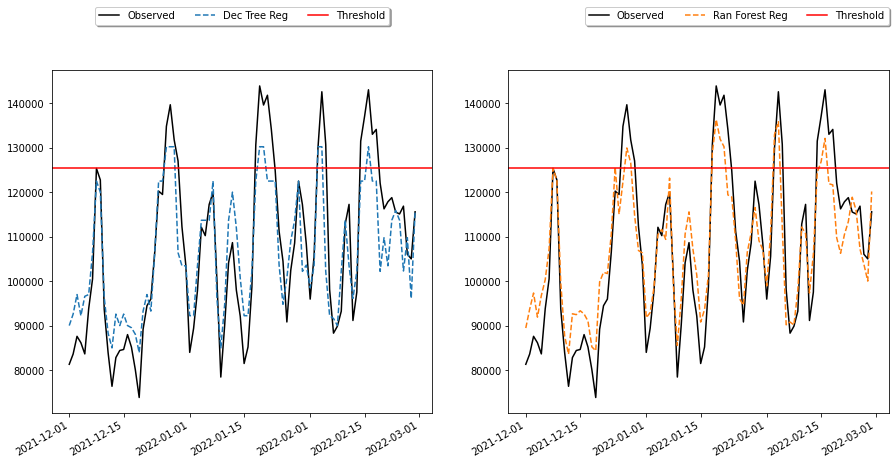

In [96]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
# Dec Tree
ax1.plot(predict_table_dt.loc['2021-12-01':'2022-03-01','Operational Demand (MW)'], label='Observed', c='k')
ax1.plot(predict_table_dt.loc['2021-12-01':'2022-03-01','predict'], label='Dec Tree Reg', ls='--', c='C0')
ax1.axhline(y = ave_threshold, label='Threshold', c='red')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.20),ncol=3, fancybox=True, shadow=True);

# Ran Forest
ax2.plot(predict_table_rf.loc['2021-12-01':'2022-03-01','Operational Demand (MW)'], label='Observed', c='k')
ax2.plot(predict_table_rf.loc['2021-12-01':'2022-03-01','predict'], label='Ran Forest Reg', ls='--', c='C1')
ax2.axhline(y = ave_threshold, label='Threshold', c='red')
ax2.legend(loc='upper center', bbox_to_anchor=(0.6, 1.20), ncol=3, fancybox=True, shadow=True);

fig.autofmt_xdate()

## Metrics of peak5

In [144]:
tru = predict_table_dt['Operational Demand (MW)'].copy()
for i in range(len(tru)):
    if tru[i] in peak_true['Operational Demand (MW)'].tolist():
        tru[i] = 1
    else:
        tru[i] = 0

In [145]:
# Metrics
print('Decision Tree')
dtpre = predict_table_dt['predict'].values

dt_pre = np.zeros(dtpre.shape)
dt_pre[dtpre > ave_threshold]=1

cm1 = confusion_matrix(tru.values,dt_pre)
print('Confusion Matrix for DT(BOM): \n', cm1)
total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)




print(" ")
print('Random Forest')

rfpre = predict_table_rf['predict'].values

rf_pre = np.zeros(rfpre.shape)
rf_pre[rfpre > ave_threshold]=1

cm2 = confusion_matrix(tru.values,rf_pre)
print('Confusion Matrix for RF(BOM): \n', cm2)
total2=sum(sum(cm2))
#####from confusion matrix calculate accuracy
accuracy2=(cm2[0,0]+cm2[1,1])/total2
print ('Accuracy : ', accuracy2)

sensitivity2 = cm2[0,0]/(cm2[0,0]+cm2[0,1])
print('Sensitivity : ', sensitivity2 )

specificity2 = cm2[1,1]/(cm2[1,0]+cm2[1,1])
print('Specificity : ', specificity2)

Decision Tree
Confusion Matrix for DT(BOM): 
 [[81  4]
 [ 1  4]]
Accuracy :  0.9444444444444444
Sensitivity :  0.9529411764705882
Specificity :  0.8
 
Random Forest
Confusion Matrix for RF(BOM): 
 [[79  6]
 [ 0  5]]
Accuracy :  0.9333333333333333
Sensitivity :  0.9294117647058824
Specificity :  1.0


## SHAP Explain

In [91]:
shap.initjs()
row_choose = 3
explainer = shap.TreeExplainer(forest_model)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value, shap_values[row_choose], X_test.iloc[row_choose])

In [92]:
shap.force_plot(explainer.expected_value, shap_values,X_test)

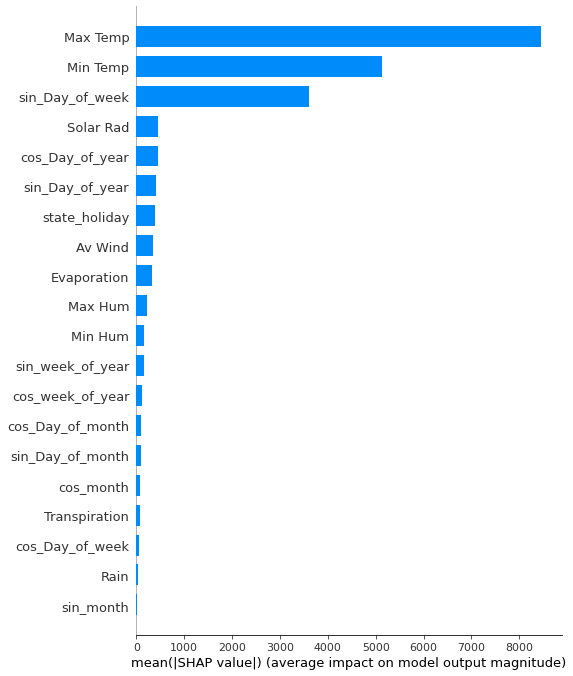

In [93]:
shap_values = shap.TreeExplainer(forest_model).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

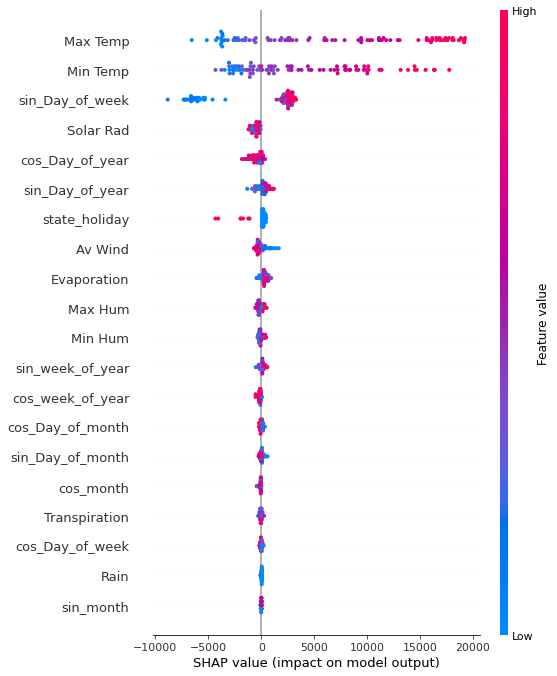

In [94]:
shap.summary_plot(shap_values, X_test)

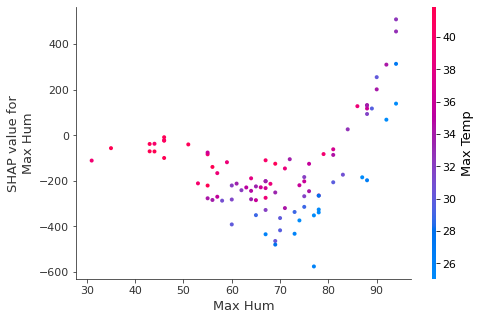

In [95]:
# Part
shap.dependence_plot('Max Hum', shap_values, X_test)